In [1]:
import sys
sys.path.append('../src')

In [2]:
import numpy as np
from mcmc.mcmc import StructureMCMC
from mcmc.data import SyntheticDataset
from mcmc.proposals import GraphProposal
from mcmc.scores import BGeScore

# for reproducibility
np.random.seed(100)

ModuleNotFoundError: No module named 'mcmc'

In [3]:
# setup synthetic data

num_nodes = 5
node_labels = [chr(ord('a') + i) for i in range(num_nodes)]
num_obs = 200
degree = 2

synthetic_data = SyntheticDataset(num_nodes=num_nodes, num_obs=num_obs, node_labels=node_labels, degree=degree)

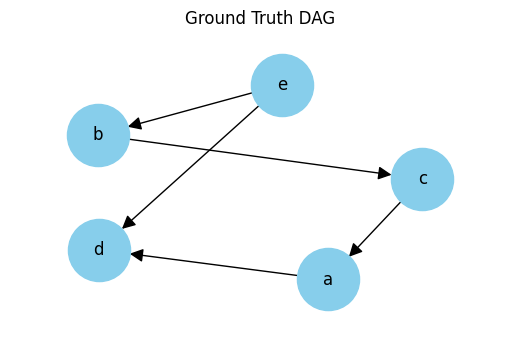

In [4]:
# visualise ground truth DAG
from mcmc.utils.graph_utils import plot_graph_from_adj_mat
plot_graph_from_adj_mat(synthetic_data.adj_mat.values, node_labels, title="Ground Truth DAG")

In [5]:
synthetic_data.data

,a,b,c,d,e
0,-0.196445,-0.039365,0.005593,-0.453780,-0.453966
1,0.928469,0.584385,-0.133857,1.102345,-0.030515
2,-0.195909,-1.806724,-1.310008,0.987758,-0.783253
3,3.672439,-1.553858,-2.504501,5.624512,-1.207085
4,2.118560,-1.030663,-0.707275,2.436619,0.005117
...,...,...,...,...,...
195,-3.726553,1.021710,2.485784,-5.164662,1.223314
196,8.735060,-2.204730,-4.911152,11.896884,-1.547577
197,-8.914967,2.234533,5.129776,-7.948369,1.181551
198,2.846533,-1.604027,-1.664003,3.002756,-0.592358


In [6]:
# setup mcmc

n_iterations = 100000
M = StructureMCMC(data=synthetic_data.data, max_iter=n_iterations, pc_init=False)

Running PC algorithm


In [7]:
# run experiment

mcmc_results, acceptance = M.run()
graphs = M.get_mcmc_res_graphs(mcmc_results)
print('Acceptance_ratio:', acceptance)

Acceptance_ratio: 0.1764


In [8]:
from mcmc.utils.graph_utils import generate_key_from_adj_matrix

graphs = M.get_mcmc_res_graphs(mcmc_results)

key = generate_key_from_adj_matrix(synthetic_data.adj_mat.values)
keys, counts = np.unique([generate_key_from_adj_matrix(g) for g in graphs], return_counts=True)
print(key in keys)

True


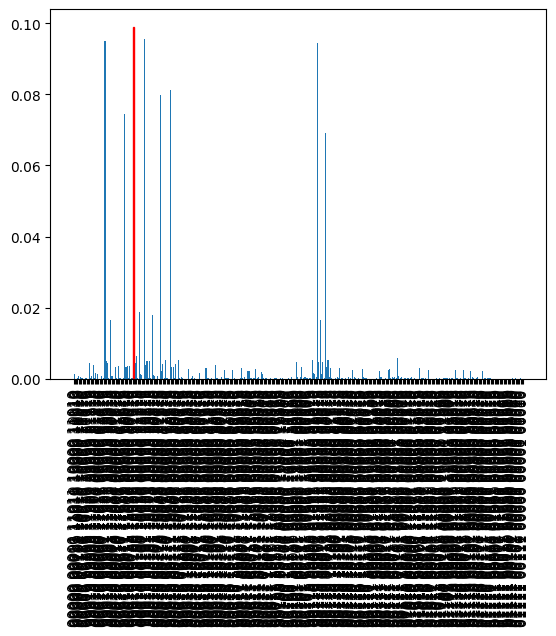

In [9]:
from matplotlib import pyplot as plt

bars = plt.bar(range(len(keys)), counts/len(graphs))
plt.xticks(range(len(keys)), keys, rotation=90);
bars[np.where(keys==key)[0][0]].set_color('red')